<a href="https://colab.research.google.com/github/shahtvisha/ImageProcessing/blob/main/ImageGenerationWithGAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize images to [-1, 1]

# Define the generator model
def build_generator():
    model = models.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [2]:
# Define the discriminator model
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Create instances of generator and discriminator
generator = build_generator()
discriminator = build_discriminator()

# Define loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Define generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Define optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)




In [4]:
# Define training loop
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



In [7]:
# Training loop
EPOCHS = 50
BATCH_SIZE = 128
BUFFER_SIZE = train_images.shape[0]
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
    for image_batch in train_dataset:
        train_step(image_batch)

    # Generate and save images after every 10 epochs
    if (epoch + 1) % 10 == 0:
        noise = tf.random.normal([1, 100])
        generated_image = generator(noise, training=False)
        generated_image = (generated_image + 1) / 2.0  # Rescale to [0, 1]
        generated_image = generated_image.numpy().reshape(28, 28)
        plt.imshow(generated_image, cmap='gray')
        plt.axis('off')
        plt.savefig(f'generated_image_epoch_{epoch+1}.png')
        plt.close()

In [10]:
from PIL import Image

# Function to print generated image
def print_generated_image(epoch):
    image_path = f'generated_image_epoch_{epoch}.png'
    try:
        generated_image = Image.open(image_path)
        generated_image.show()
    except FileNotFoundError:
        print(f"Generated image for epoch {epoch} not found.")

# Call the function to print the generated image for a specific epoch
print_generated_image(10)  # Change the epoch number as needed


In [13]:
import matplotlib.image as mpimg

# Function to display an image
def display_image(image_path):
    try:
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.axis('off')  # Turn off axis
        plt.show()
    except FileNotFoundError:
        print(f"Image file '{image_path}' not found.")
    except Exception as e:
        print(f"Error occurred while trying to display the image: {str(e)}")

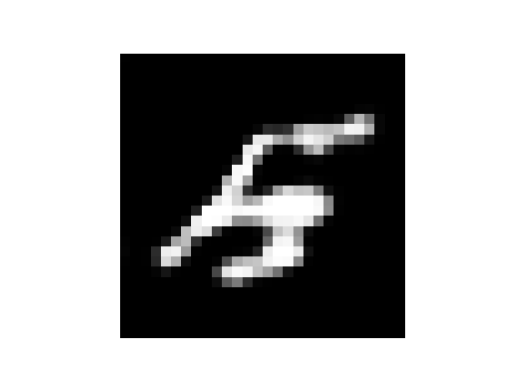

In [14]:
display_image("/content/generated_image_epoch_10.png")


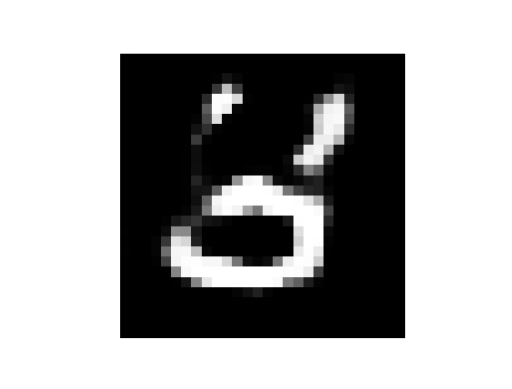

In [15]:
display_image("/content/generated_image_epoch_20.png")


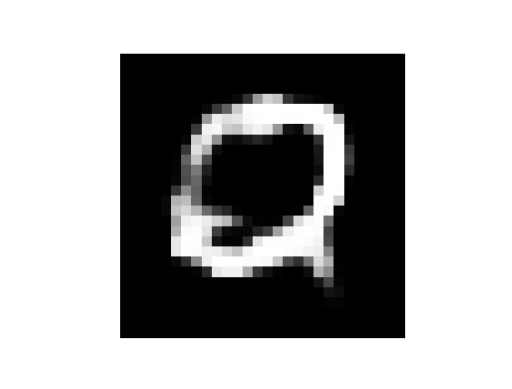

In [16]:
display_image("/content/generated_image_epoch_30.png")


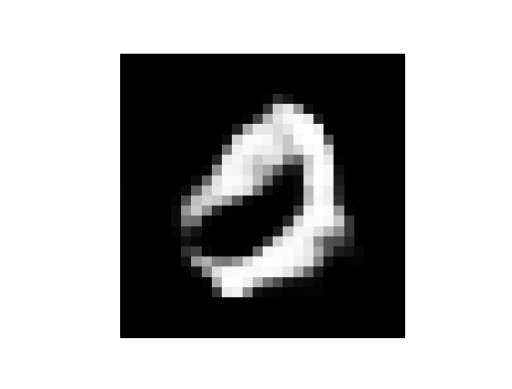

In [17]:
display_image("/content/generated_image_epoch_40.png")


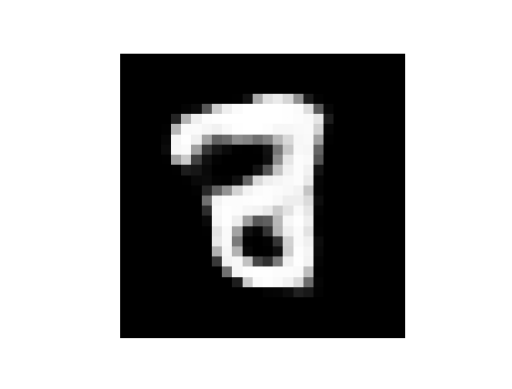

In [18]:
display_image("/content/generated_image_epoch_50.png")
